# Restaurant data for slalom AI for All challenge

Given the data sets from the slalom team, analyzie and figure out a model to predict revenue vs location

Notes:
our "client" provides a drive-thru experience, with some mobile ordering.
The data set contains features for:
* City,
* City Group,
* Restaurant type,
* Open date,
* Revenue

The dataset also contains fields for which we have no information and these are not used creating the prediction model.


### Restatement of the business problem:

Produce a model, which when given a single tupple of data, can predict revenue.

The tupple consists of City Group, Restaurant Type, and Open Date

In [2]:
!pip install xgboost

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold


# Initial Exploratory data analysis

Explore the provided training and test data, describe it and provide some illustration of the data...


In [4]:
train = pd.read_csv('train_data.csv')
#anna
test_df = pd.read_csv('./test_data.csv')
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,4244605.96
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,3287351.70
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,4219403.66
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,3.0,0,4,0,0,0,0,0,0,3937158.64
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,5877728.96


In [5]:
train.shape

(99710, 43)

In [6]:
test_df.shape

(137, 42)

start with some descriptions of the training data...

First have a go at the numeric columns (the so called "PX" columns), which we have very little data on.  And a quick ccheck to make sure i did not miss something in my 'openrefine' efforts.

In [7]:
train.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,...,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,99710.000000,9.971000e+04
mean,50002.992980,4.093762,4.431978,4.215766,4.398501,1.991385,2.878799,5.301083,4.931140,5.252161,...,3.088948,2.087103,1.195076,1.946023,0.988888,2.111303,1.834741,1.971758,0.975058,4.809134e+06
std,28869.067522,2.813350,1.426747,0.842940,1.035292,1.065730,1.530582,2.180389,1.720239,1.704360,...,1.781155,4.313285,2.308883,3.974532,1.535414,4.686425,3.229393,3.807489,1.678317,1.197243e+06
min,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.881144e+06
25%,25000.250000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.089145e+06
50%,50004.500000,3.000000,5.000000,4.000000,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.709871e+06
75%,75002.750000,4.000000,5.000000,4.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.419663e+06
max,99999.000000,15.000000,7.500000,6.000000,7.500000,6.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,25.000000,15.000000,25.000000,6.000000,30.000000,15.000000,20.000000,8.000000,1.284582e+07


In [8]:
train.isnull().sum().sort_index()/len(train)

City          0.0
City Group    0.0
Id            0.0
Open Date     0.0
P1            0.0
P10           0.0
P11           0.0
P12           0.0
P13           0.0
P14           0.0
P15           0.0
P16           0.0
P17           0.0
P18           0.0
P19           0.0
P2            0.0
P20           0.0
P21           0.0
P22           0.0
P23           0.0
P24           0.0
P25           0.0
P26           0.0
P27           0.0
P28           0.0
P29           0.0
P3            0.0
P30           0.0
P31           0.0
P32           0.0
P33           0.0
P34           0.0
P35           0.0
P36           0.0
P37           0.0
P4            0.0
P5            0.0
P6            0.0
P7            0.0
P8            0.0
P9            0.0
Type          0.0
revenue       0.0
dtype: float64

# Analysis of the Revenue data in the training set

In [8]:
# First, let's generate descriptive statistics for the revenue column

train['revenue'].describe()

count    9.971000e+04
mean     4.809134e+06
std      1.197243e+06
min      1.881144e+06
25%      4.089145e+06
50%      4.709871e+06
75%      5.419663e+06
max      1.284582e+07
Name: revenue, dtype: float64

A simple box plot will give us a visual diagram to show the mean, min, max and percentiles of the revenue column.  The box plot reveals that most of the per store revenue falls between: $200,000 and $800,000.

[Text(0.5, 1.0, 'Box Plot for Revenue variable')]

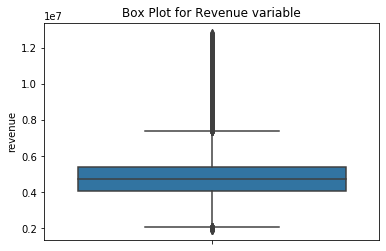

In [15]:
sns.boxplot(y = train['revenue']).set(title="Box Plot for Revenue variable")



Create a histogram and check for skew and distribution...

Visual inspection of the Left hand diagram reveals a little skew to the right (notice the tail out to the right from the black line).  This would indicate that there are outlier revenue points in the data.

The the right hand diagram, the probability plot of the training data,  Also shows the skew present in the data. The blue line is the analysis of the training data and the red line is the theoretical. As you can see there are some issues at  the ends. The curve looks a little like a "C", showing the Right Skew of the data

Bottom line:
We'll have to do some transformations on the revenue. We want the revenue column to be as close to a "normal distribution" shape as possible. Let's use the logarithic and Square transformations and compare.


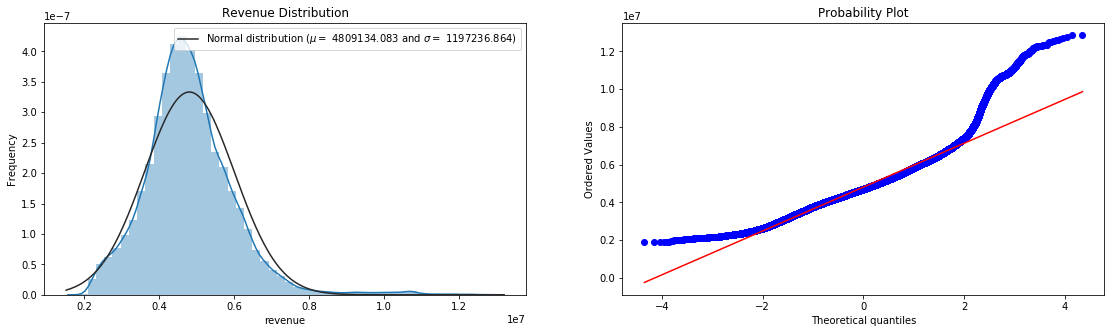

In [10]:
# first compare the distrubtion, to check for any skew

(mu, sigma) = norm.fit(train['revenue'])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(train['revenue'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Revenue Distribution')
ax2 = stats.probplot(train['revenue'], plot=plt)
f.show();


Apply a log and a square transformation  to the revenue column.

Text(0.5, 1.0, 'Square distribution plot for revenue')

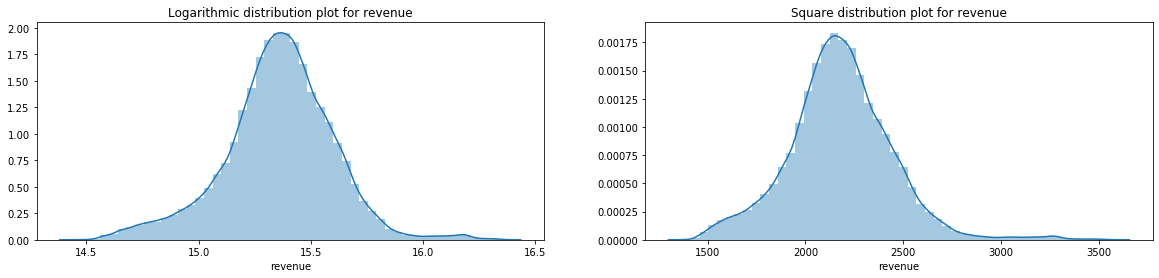

In [11]:
ig, ax = plt.subplots(1,2,figsize=(20,4))

sns.distplot(np.log(train['revenue']),ax=ax[0]).set_title("Logarithmic distribution plot for revenue")

sns.distplot(np.sqrt(train['revenue']),ax=ax[1]).set_title("Square distribution plot for revenue")

The logarithmic transformation seems to reduce the skew.  But, the skew is still there.

What does dropping outliers look like?

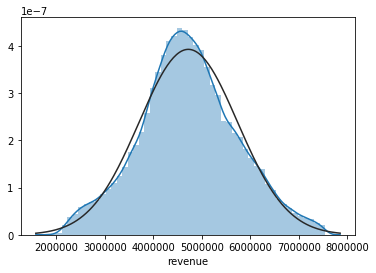

In [13]:
train_out = train[train['revenue']<train['revenue'].quantile(0.98)]
sns.distplot(train_out['revenue'], fit=norm)

Dropping the outliers simply chops off the right tail. With the normal distribution overlaid, the transformed revenue column mostly fits under the normal curve.

# Analysis of the restaurant type and city features

## Visualize the restaurant 'Type' column

Let's check to see what types of restaurants are in the training data set.  
Note:
DT = "Drive thru", 
IL = "in line"
FC = "Food Court"
MB = "Mobile"

We see from the next diagram that there are no "Mobile" restaurants.  Food court and inline dominate.

As far as "City Group" = just about the same number  of "big city" as "other"

In [12]:
print("Number of restaurant by type: Training set")
print(train['Type'].value_counts())

Number of restaurant by type: Training set
FC    57019
IL    40447
DT     2244
Name: Type, dtype: int64


In [13]:
print("Number of restaurants by type: Test set")
print(test_df['Type'].value_counts())

Number of restaurants by type: Test set
FC    76
IL    60
DT     1
Name: Type, dtype: int64


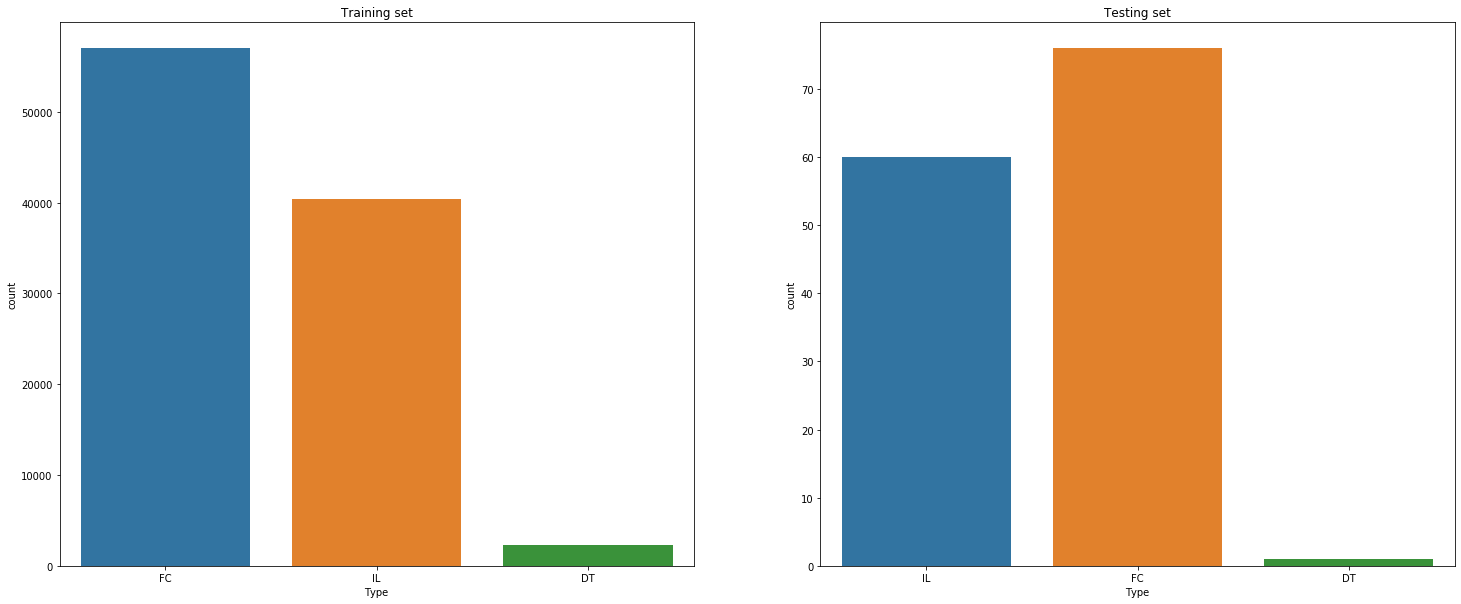

In [14]:
fig, ax = plt.subplots(1,2,figsize=(25,10))
sns.countplot(x=train['Type'],ax=ax[0]).set_title("Training set")
sns.countplot(x=test_df['Type'],ax=ax[1]).set_title("Testing set")

fig.show()

## Summary

In the training set, food court and in-line restaurant types are the most prevelent.


# Visualize the 'City Group' column

Training set :
Other         50552
Big Cities    49158
Name: City Group, dtype: int64
-------------
Testing set :
Big Cities    78
Other         59
Name: City Group, dtype: int64


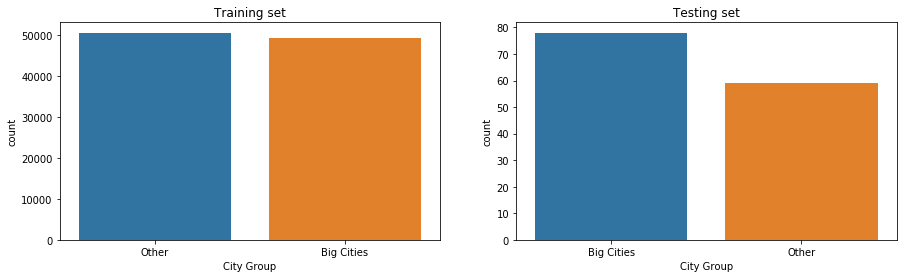

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
sns.countplot(x=train['City Group'],ax=ax[0]).set_title("Training set")
print("Training set :")
print(train['City Group'].value_counts())

sns.countplot(x=test_df['City Group'],ax=ax[1]).set_title("Testing set")
print("-------------")
print("Testing set :")
print(test_df['City Group'].value_counts())

## Visualize the City column

How many cities are represented in training and test data? Also, let's provide a count of restaurants / city

In [16]:
(train['City'].nunique(), test_df['City'].nunique())

(57, 34)

There are 57 unique cities in the training set and 34 in the test set.

By inspection, we see that Istanbul accounts for the most restaurants. Ankara, Kocaeli and Izmir also have a large number of locations.

Text(0.5, 1.0, 'Countplot for City - Training set')

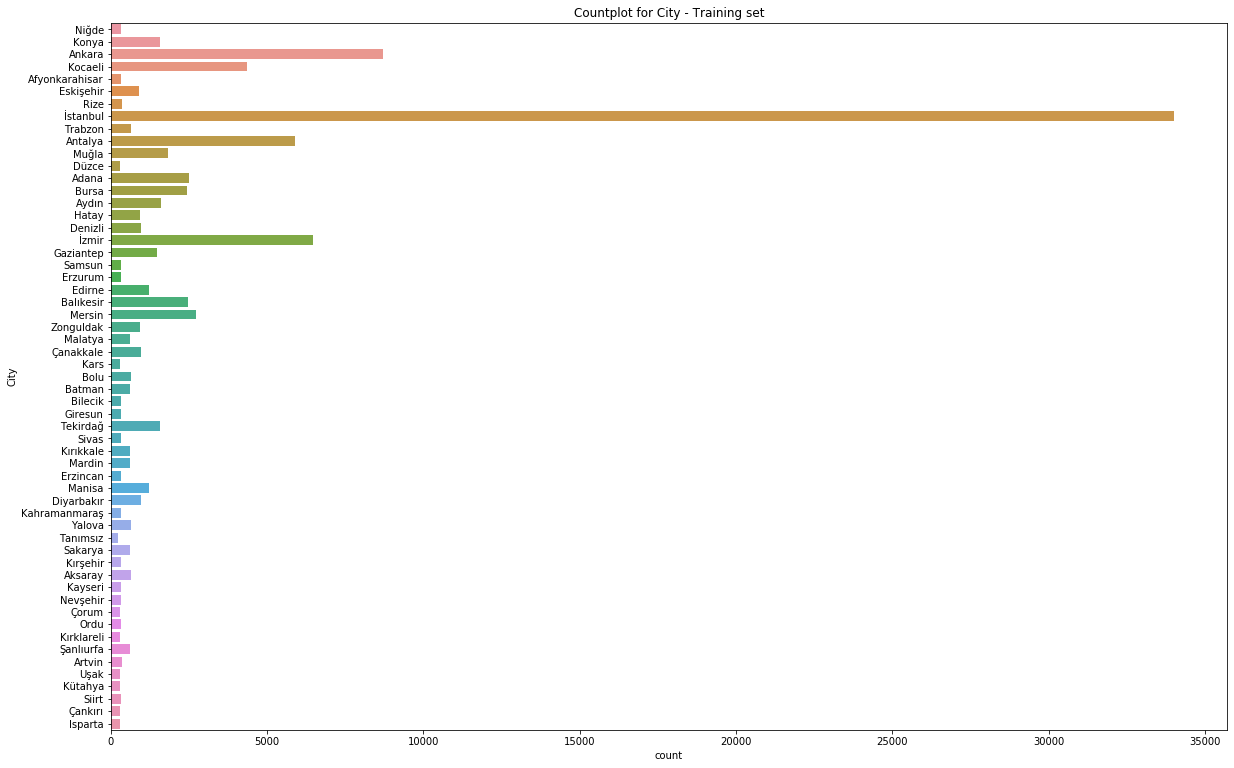

In [17]:
plt.figure(figsize=(20,13))
sns.countplot(y=train['City']).set_title("Countplot for City - Training set")

Text(0.5, 1.0, 'Countplot for City - Testing set')

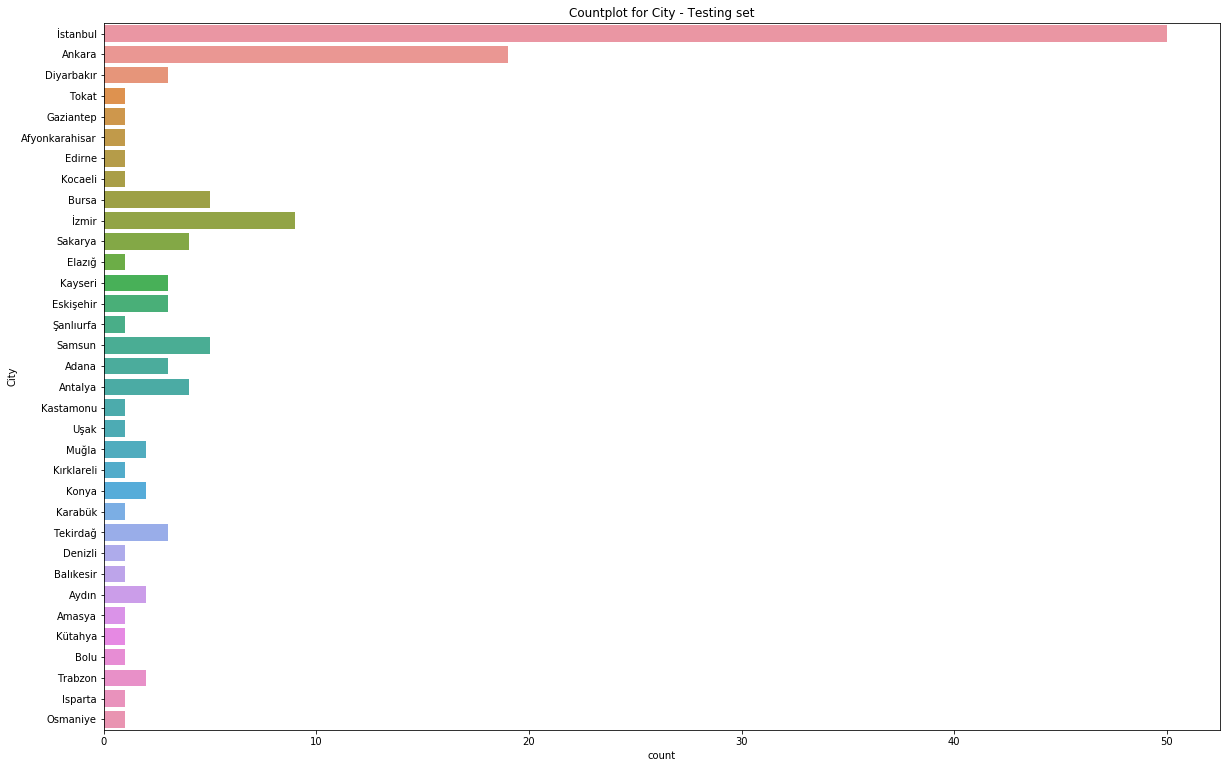

In [18]:


plt.figure(figsize=(20,13))
sns.countplot(y=test_df['City']).set_title("Countplot for City - Testing set")



In [19]:
counts = train['City'].value_counts() #counts unique values
percent = ((train['City'].value_counts()/train['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(5)

,count,percentage
İstanbul,34004,34.1%
Ankara,8700,8.7%
İzmir,6454,6.5%
Antalya,5900,5.9%
Kocaeli,4355,4.4%


In [20]:
counts = test_df['City'].value_counts() 
percent = ((test_df['City'].value_counts()/test_df['City'].value_counts().sum())*100).round(1).astype(str) + '%'
pd.DataFrame({'count':counts,'percentage':percent}).head(5)

,count,percentage
İstanbul,50,36.5%
Ankara,19,13.9%
İzmir,9,6.6%
Bursa,5,3.6%
Samsun,5,3.6%


## Summary

From a percentage point of view, 60% of the restaurants in the training data are accounted for from 3 cities: 
Istanbul, Ankara and Izmir. Respectively, 

* Istambul accounts for 34% of  training set and  36.5% of test, 
* Ankara accounts for 8.7% of training and 13.9% of test

# Analysis of Revenue by year



Let's discover information about the "Open Year" column. This column tells us when a restaurant opened.  We will transform the "Open Year" column into:

* "Year" - year this restaurant opened
* "Month" - month it opened
* "Years old" how long the restaurant has been open in years

First, let's find how training data revenue is distributed by year.


Text(0.5, 1.0, 'Year vs Revenue')

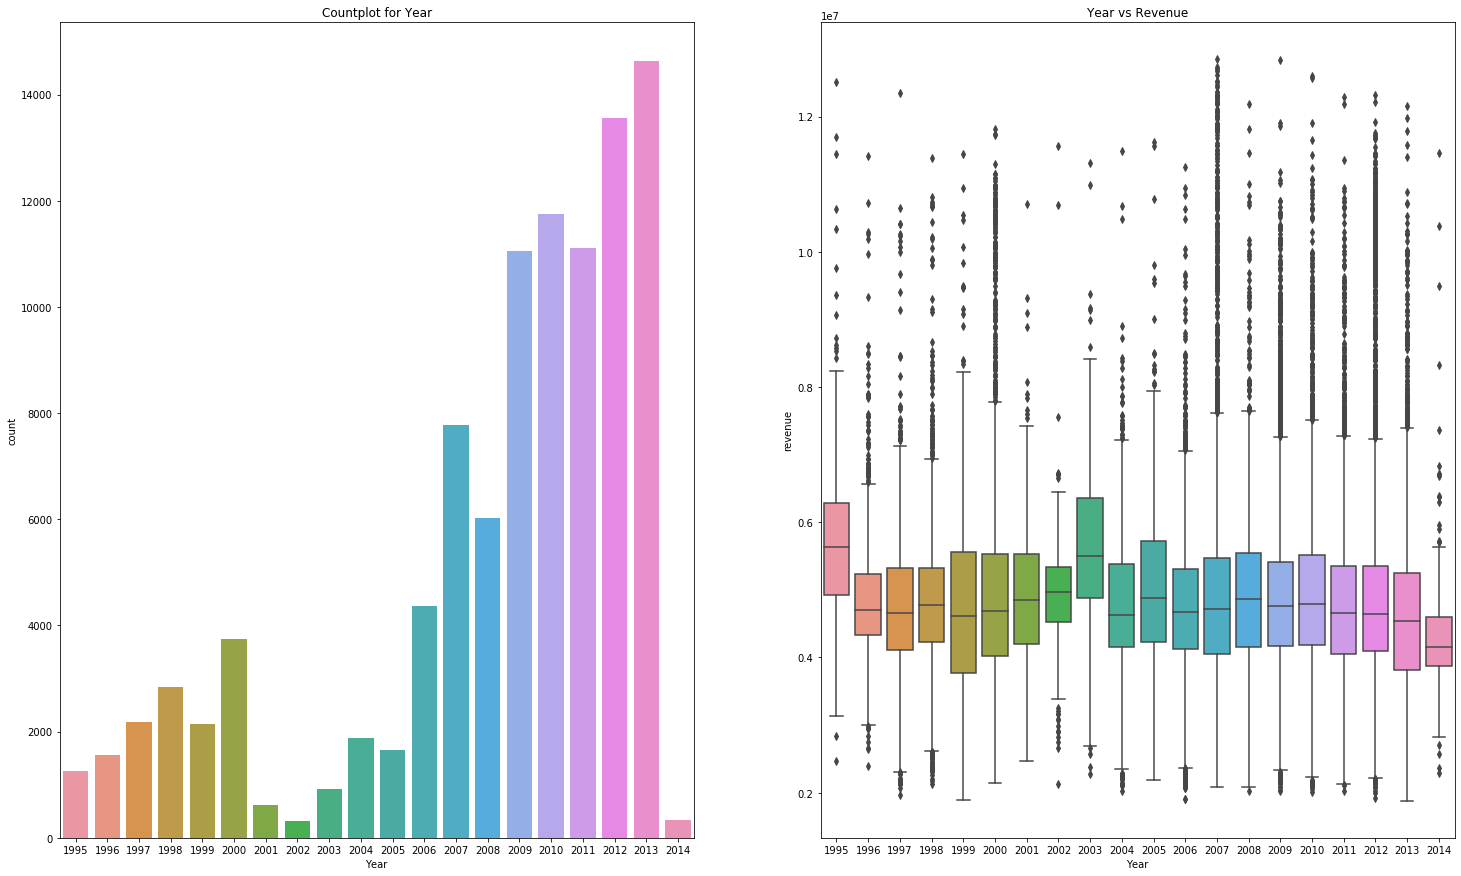

In [21]:
# transform the 'Open Date' feature
def newFeatures(df):
  df['Date'] = pd.to_datetime(df['Open Date'],format="%m/%d/%Y")
  df['Year'] = df['Date'].dt.year
  df['Month'] = df['Date'].dt.month
  df['Years Old'] = pd.to_datetime('23-03-2015').year - df['Date'].dt.year
  df = df.drop(['Open Date','Date'],axis=1)
  return df

train = newFeatures(train)


fig, ax = plt.subplots(1,2,figsize=(25,15))   
sns.countplot(x=train['Year'],ax=ax[0])
ax[0].set_title("Countplot for Year")

sns.boxplot(y=train['revenue'],x=train['Year'],ax=ax[1]).set_title("Year vs Revenue")

## 1st observation on Revenue growth in the Training data

Around 2007, the comapny began to experienced signitificant revenue growth. 

### Where did this growth happen?

First, analyze revenue by restaurant type:


[Text(0.5, 1.0, 'Violinplot of Type vs Revenue')]

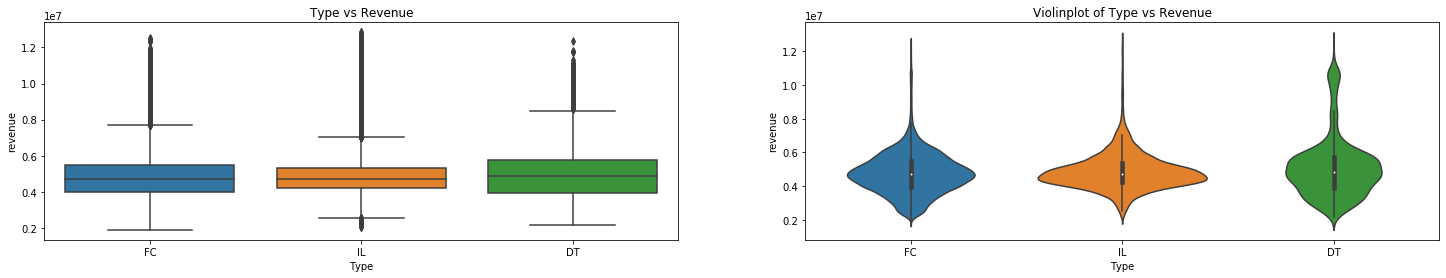

In [24]:


fig, ax = plt.subplots(1,2,figsize=(25,4))    
sns.boxplot(y=train['revenue'],x=train['Type'],ax=ax[0]).set(title='Type vs Revenue')
sns.violinplot(y=train['revenue'],x=train['Type'],ax=ax[1]).set(title='Violinplot of Type vs Revenue')



Food court, in-line and Drive through all contributed to growing revenue.

[Text(0.5, 1.0, 'City Group vs Revenue')]

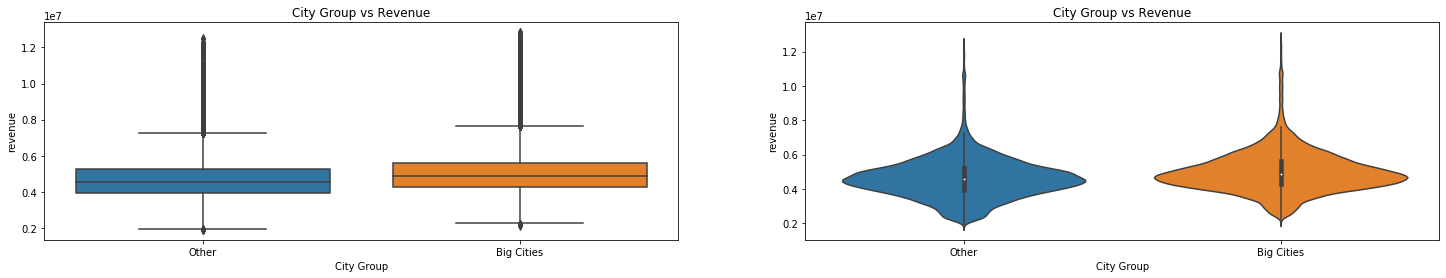

In [17]:
# check 'City Group'
fig, ax = plt.subplots(1,2,figsize=(25,4))    
sns.boxplot(y=train['revenue'],x=train['City Group'],ax=ax[0]).set(title='City Group vs Revenue')
sns.violinplot(y=train['revenue'],x=train['City Group'],ax=ax[1]).set(title='City Group vs Revenue')

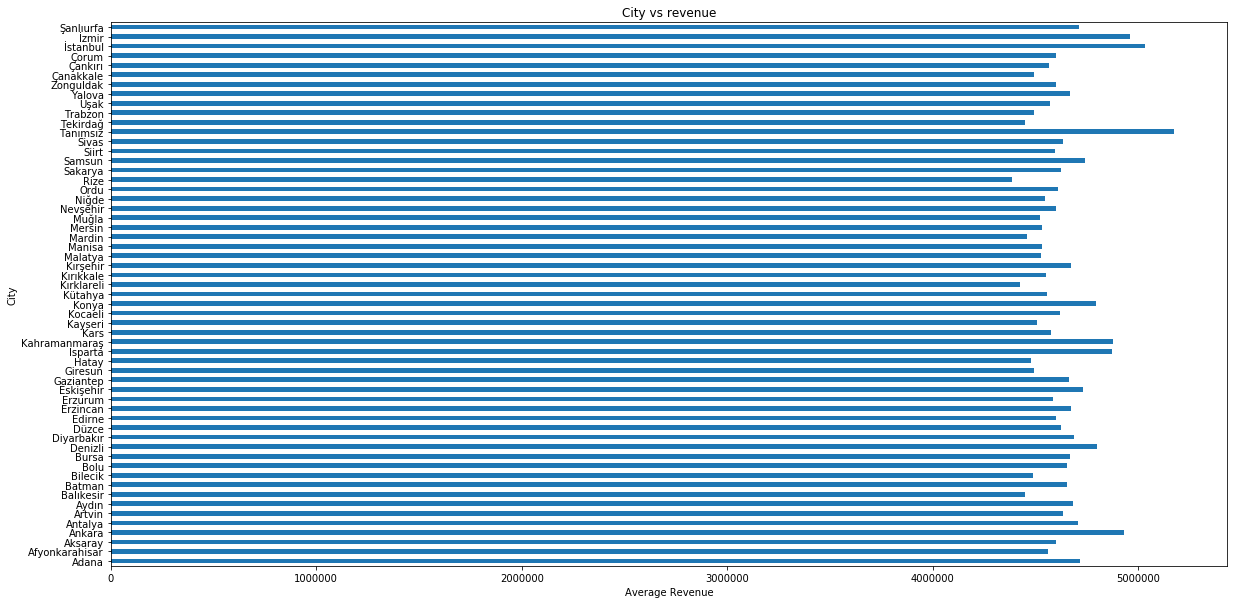

In [29]:


train.groupby(['City']).mean()['revenue'].plot.barh(figsize=(20,10))
plt.yticks(fontsize=10)
plt.title('City vs revenue')
plt.xlabel('Average Revenue')
plt.show()



Big cities had a slightly higher impact on revenue.

Revenue by city is tightly grouped in the training dataset.

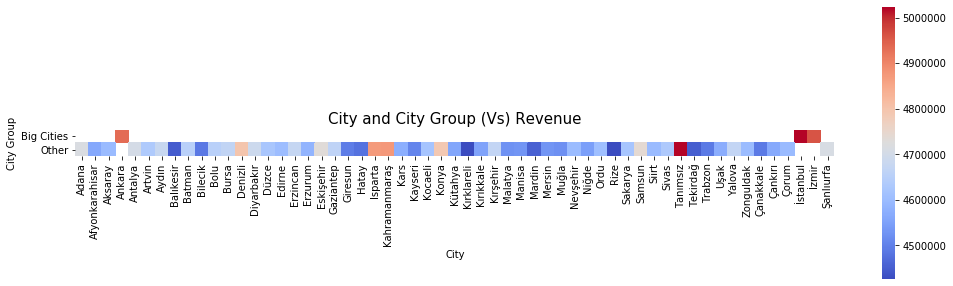

In [16]:

df = pd.DataFrame({'City Group':train['City Group'],'City':train['City'],'revenue':train['revenue']})

df_wide=df.pivot_table( index='City Group', columns='City', values='revenue')

fig, ax = plt.subplots(figsize=(17,5))         # Sample figsize in inches
plot = sns.heatmap(df_wide, annot=False,ax=ax,cmap='coolwarm',robust=True, square=True) #annot=True writes data in rect boxes
plt.title('City and City Group (Vs) Revenue',size=15)
plt.show()




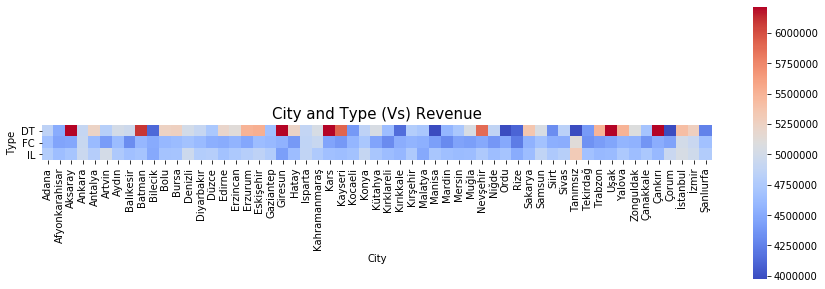

In [33]:
df = pd.DataFrame({'Type':train['Type'],'City':train['City'],'revenue':train['revenue']})

df_wide=df.pivot_table( index='Type', columns='City', values='revenue')

fig, ax = plt.subplots(figsize=(15,5))         # Sample figsize in inches
plot = sns.heatmap(df_wide, annot=False,ax=ax,cmap='coolwarm',robust=True, square=True,) #annot=True writes data in rect boxes
plt.title('City and Type (Vs) Revenue',size=15)
plt.show()

### Summary

Food court, in-line and Drive through restaurant types all contributed to revenue. Big cities and 'other type' cities were about even contributors to revenue. 

The previous diagram shows that Drive Through type restaurants had a large impact on revenue overall.  Even though there were less Drive Through restaurants, they generated significantly more revenue.  Food court type restaurants were consistent revenue generators